In [5]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
import os
import keras
import math
import numpy as np

use_full = true

# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
#top_model_weights_path = '../model/bottleneck_fc_model.h5'
top_model_weights_path = '../model/bottleneck_fc_model_inceptionv3_500_val_acc_4791.h5'
#top_model_weights_path = '../model/fc_model.h5'
img_width, img_height = 500, 500

#full
if use_full:
    train_data_dir = '../data/Pandora18K_train_val_test_split/train'
    validation_data_dir = '../data/Pandora18K_train_val_test_split/val'
    test_data_dir = '../data/Pandora18K_train_val_test_split/test'
    nb_train_samples = 14313
    nb_validation_samples = 1772
    nb_test_samples = 1791
    total_num_classes = 18
    validation_labels = np.array([0]*72+[1]*73+[2]*72+[3]*93+[4]*78+[5]*74+[6]*85+[7]*124+[8]*131+[9]*118+[10]*109+[11]*105+[12]*80+[13]*130+[14]*108+[15]*89+[16]*111+[17]*120)
else:
    train_data_dir = '../data/Pandora18K_small_train_val_test_split/train'
    validation_data_dir = '../data/Pandora18K_small_train_val_test_split/val'
    test_data_dir = '../data/Pandora18K_small_train_val_test_split/test'
    nb_train_samples = 1462
    nb_validation_samples = 167
    nb_test_samples = 171
    total_num_classes = 18
    validation_labels = np.array([0]*8+[1]*10+[2]*11+[3]*5+[4]*11+[5]*6+[6]*8+[7]*8+[8]*9+[9]*12+[10]*7+[11]*10+[12]*14+[13]*5+[14]*11+[15]*11+[16]*12+[17]*9)

epochs = 2
batch_size = 32

In [6]:

# build the VGG16 network
base_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width,img_height,3))
#base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.6))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(.6))
top_model.add(Dense(18, activation='softmax'))

top_model.load_weights(top_model_weights_path)

model = Model(input= base_model.input, output= top_model(base_model.output))

Model loaded.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


In [7]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale= 1./255)

valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen  = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False)

if False:
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
                  metrics=['accuracy'])
    _, sanity_acc = model.evaluate_generator(generator = validation_generator, steps = nb_validation_samples // batch_size)
    print("sanity_acc = " + str(sanity_acc))


Found 14313 images belonging to 18 classes.
Found 1772 images belonging to 18 classes.
Found 1791 images belonging to 18 classes.


In [8]:
pretrained_model = "part_3_weights"
weight_dir = "../model/%s"%pretrained_model
if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)

best_weight_path = "../model/best.h5"
best_acc = 0
best_lr = 0
best_momentum = 0
best_frozen = 0
num_parameter_sets = 1
    
for i in range(num_parameter_sets):
    print("\n")
    
    lr = 10**np.random.uniform(low=-7, high=-5)
    momentum = np.random.uniform(low = 0.8, high = 0.9)
    num_frozen = np.random.randint(300, high=312) #312 total
    print("lr = " + str(lr))
    print("momentum = " + str(momentum))
    print("number of frozen layers = " + str(num_frozen))
    
    # build the VGG16 network
    base_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(0.6))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(.6))
    top_model.add(Dense(18, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(input= base_model.input, output= top_model(base_model.output))
    
    for layer in model.layers:
        layer.trainable = True
    
    for layer in model.layers[:num_frozen]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=lr),
                  momentum=momentum,
                  metrics=['accuracy'])
    
    param_names = "lr_" + str(lr)
    weight_path = os.path.join(weight_dir, param_names + "_best_weights%s.h5"%pretrained_model)
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=weight_path, verbose=1,monitor='val_acc', save_best_only=True, save_weights_only=True)
    stopper = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto')

    model.fit_generator(
        train_generator,
        steps_per_epoch=(nb_train_samples // batch_size)+1,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=(nb_validation_samples // batch_size)+1,
        callbacks=[checkpointer, stopper])
    
    model.load_weights(weight_path)
    new_loss, new_acc = model.evaluate_generator(generator = validation_generator, steps = (nb_validation_samples // batch_size)+1)
    print("new_acc = "+ str(new_acc))
    print("new_loss = "+ str(new_loss))
    
    if new_acc > best_acc:
        model.load_weights(weight_path)
        model.save_weights(best_weight_path, overwrite = True)
        best_acc = new_acc
        best_lr = lr
        best_momentum = momentum
        best_frozen = num_frozen
        
    os.remove(weight_path)
    
    print("best val acc so far = " + str(best_acc))
    



lr = 8.25788330216e-06
momentum = 0.852804852513
number of frozen layers = 308
Epoch 1/2
448/448 [==============================] - 776s - loss: 6.9811 - acc: 0.0974 - val_loss: 2.7750 - val_acc: 0.3335
Epoch 2/2
448/448 [==============================] - 749s - loss: 5.9722 - acc: 0.1026 - val_loss: 2.6139 - val_acc: 0.3330
new_acc = 0.333521444964
new_loss = 2.77499713505
best val acc so far = 0.333521444964


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


In [9]:
model.load_weights(best_weight_path)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=best_lr),
              momentum=best_momentum,
              metrics=['accuracy'])

val_loss, val_acc = model.evaluate_generator(generator = validation_generator, steps = (nb_validation_samples // batch_size)+1)
print("best val loss = " + str(val_loss))
print("best val acc = " + str(val_acc))

best val loss = 2.77499713505
best val acc = 0.333521444964


In [10]:
model.load_weights(best_weight_path)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=best_lr),
              momentum=best_momentum,
              metrics=['accuracy'])

test_loss, test_acc = model.evaluate_generator(generator = test_generator, steps = (nb_test_samples // batch_size)+1)
print("best test loss = " + str(test_loss))
print("best test acc = " + str(test_acc))

best test loss = 2.78051830017
best test acc = 0.33835845803


In [13]:
from keras.utils.np_utils import to_categorical

#y_test = to_categorical(validation_labels, num_classes=18)
y_test = validation_labels
prob_predict = model.predict_generator(generator = validation_generator, steps = (nb_validation_samples / batch_size) + 1, max_q_size=10, workers=1, pickle_safe=False, verbose=0)
y_pred = np.argmax(prob_predict, axis=1)

print(y_test.shape)
print(prob_predict.shape)
print(y_pred.shape)
print(y_pred)
print(y_test)

"""
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]

confusion_matrix(y_true, y_pred)

y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
"""

(1772,)
(1772, 18)
(1772,)
[17  7 16 ..., 16 17  2]
[ 0  0  0 ..., 17 17 17]


'\nfrom sklearn.metrics import confusion_matrix\ny_true = [2, 0, 2, 2, 0, 1]\ny_pred = [0, 0, 2, 2, 0, 2]\n\nconfusion_matrix(y_true, y_pred)\n\ny_true = ["cat", "ant", "cat", "cat", "ant", "bird"]\ny_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]\nconfusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])\n'


iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
(1772,)
(1772,)
Confusion matrix, without normalization
[[ 0  0  1  1  1  3  1  3  4  1  0  0  0  1  7  2 22 25]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  6  4  1 59]
 [16  7  1  3  0  0  0  0  0  0  1  2  0  0 18  0  0 24]
 [ 6 17 10 13  8  6  8  0  3  0  0  0  0  0 20  1  1  0]
 [ 0  3 12 24 21  4  6  2  0  0  0  0  0  0  2  0  2  2]
 [ 0  1  3 27 30  4  5  0  0  0  0  1  0  0  3  0  0  0]
 [ 0  0  0  6 53 14  6  1  1  0  0  0  0  0  4  0  0  0]
 [ 0  1  1  2 44 37 36  2  0  0  0  0  0  0  1  0  0  

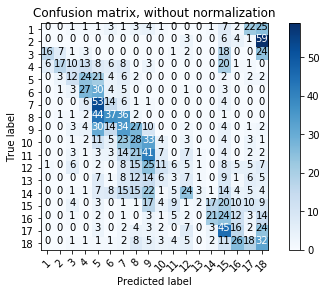

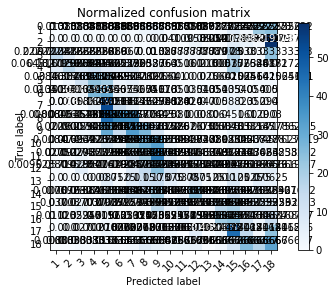

In [14]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
"""
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
"""

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
print(class_names)
print(y_test.shape)
print(y_pred.shape)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()